# DSCI 100 project writeup

Project Question: How does the player's behaviour, specifically the total sessions played, total playtime and average session length contribute to whether they subscribe to the newsletter?

Step 1: Loading libraries

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Introduction

The data comes from a Minecraft server run by a research group at UBC called the Pacific Laboratory for Artificial Intelligence, led by Frank Wood. They recorded how people played on the server, including when they were online and some basic information about them. This information was saved in a file called players.csv. The goal of the project is to help train AI to act like a real Minecraft player.

The question I will attempt to answer is: Can player experience level and total hours played predict whether a Minecraft player subscribes to the newsletter? This is a binary classification problem where the outcome is whether or not a player is subscribed, and the predictors are behavioral variables taken from their play history.

To explore this question, I will use the `players.csv` dataset provided. This dataset includes information about individual players who joined the Minecraft server. For this project, I will focus on the three variables relevant to our question.



In [4]:
players <- read_csv("players.csv") 
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


From the dataset above, there are 7 column variables, with names as follows:

* experience (character): the player's skill level (listed as Amateur, Beginner, Regular, Pro, and Veteran)
* subscribe (logical): if the player has subscribed to the game-related newsletter
* hashedEmail (character): the player's unique identifier
* played_hours (double): how many hours each player has played the game
* names (character): name of each player
* gender (character): gender of each player
* Age (double): age of each player

The data contains 196 rows with each row respresenting a single player observation, giving us 196 observations.

# Methods & Results


### Data Loading and Cleaning

The analysis began by loading the `players.csv` dataset using the `read_csv()` function from the `tidyverse` package. We focused on three variables relevant to our question: `subscribe`, `played_hours`, and `experience`.

The data was cleaned by:

- Selecting only the variables needed for the analysis.
- Converting the response variable `subscribe` to a categorical factor for classification.
- Checking for missing values and ensuring the data types were appropriate for modeling.


### Clean the data

In [14]:
player_data <- players |>
  select(subscribe, played_hours, experience) |>
  mutate(subscribe = as.factor(subscribe), experience = as.factor(experience))
player_data

subscribe,played_hours,experience
<fct>,<dbl>,<fct>
TRUE,30.3,Pro
TRUE,3.8,Veteran
FALSE,0.0,Veteran
⋮,⋮,⋮
FALSE,0.0,Amateur
FALSE,2.3,Amateur
TRUE,0.2,Pro


#### To better understand the data, we need to visualize how subscription status varies by hours played and experience level.

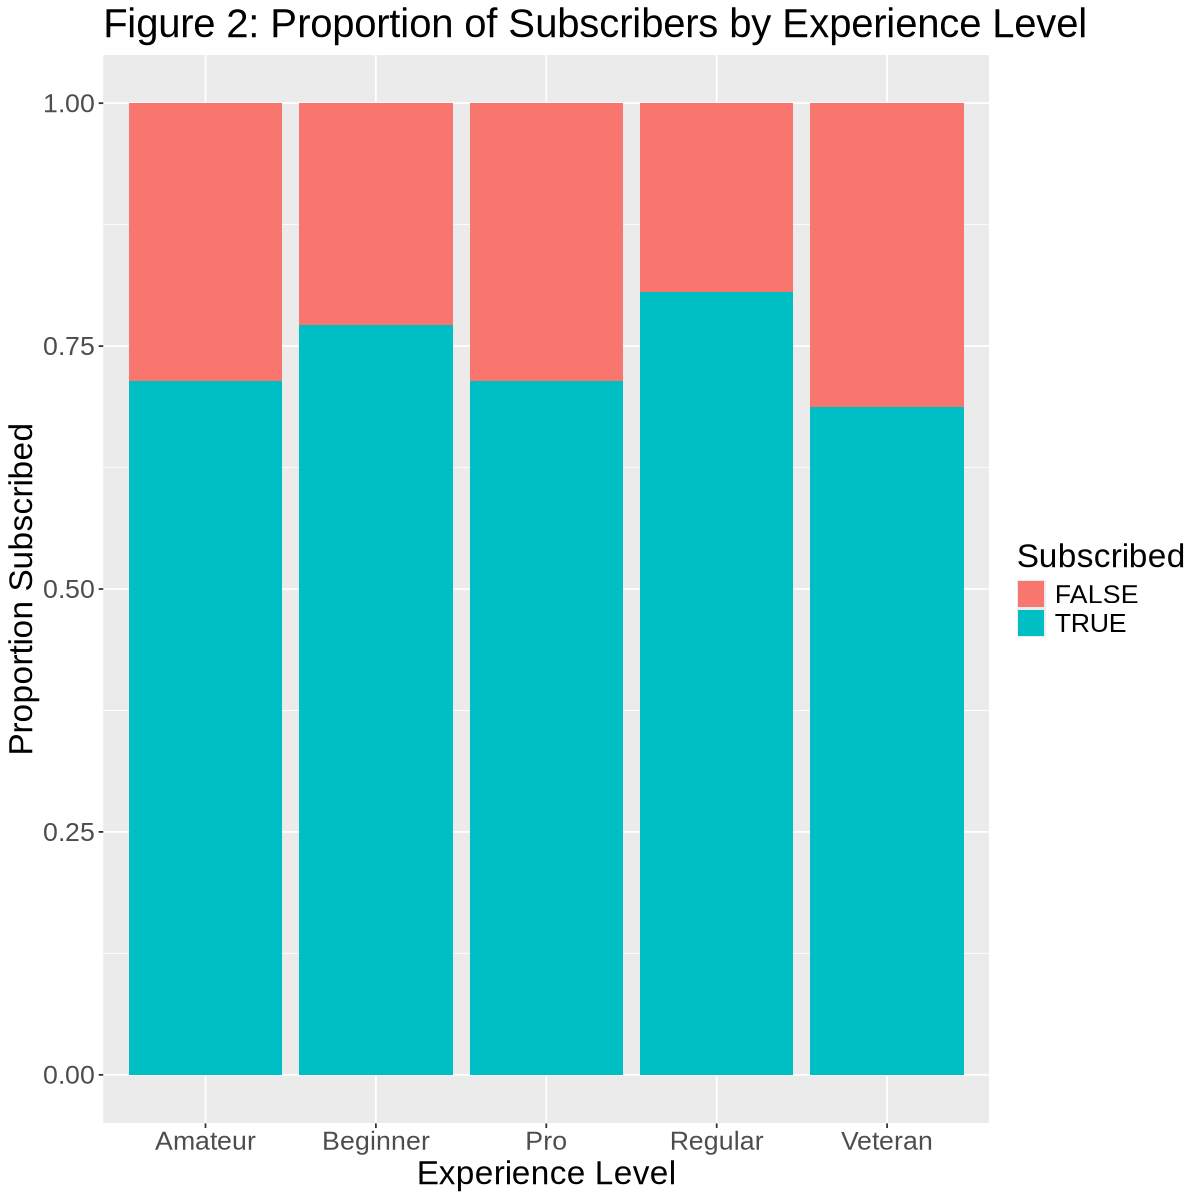

In [24]:

# Experience level vs. subscription rate
experience_plot <- ggplot(player_data, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(title = "Figure 1: Proportion of Subscribers by Experience Level",
       x = "Experience Level",
       y = "Proportion Subscribed",
       fill = "Subscribed") +
theme(text = element_text(size = 20))
experience_plot

#### As the played hours variable is mainly concentrated under 10 hours (i.e. not standardized), the subscription range needs to be separated into two graphs:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 13 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 185 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


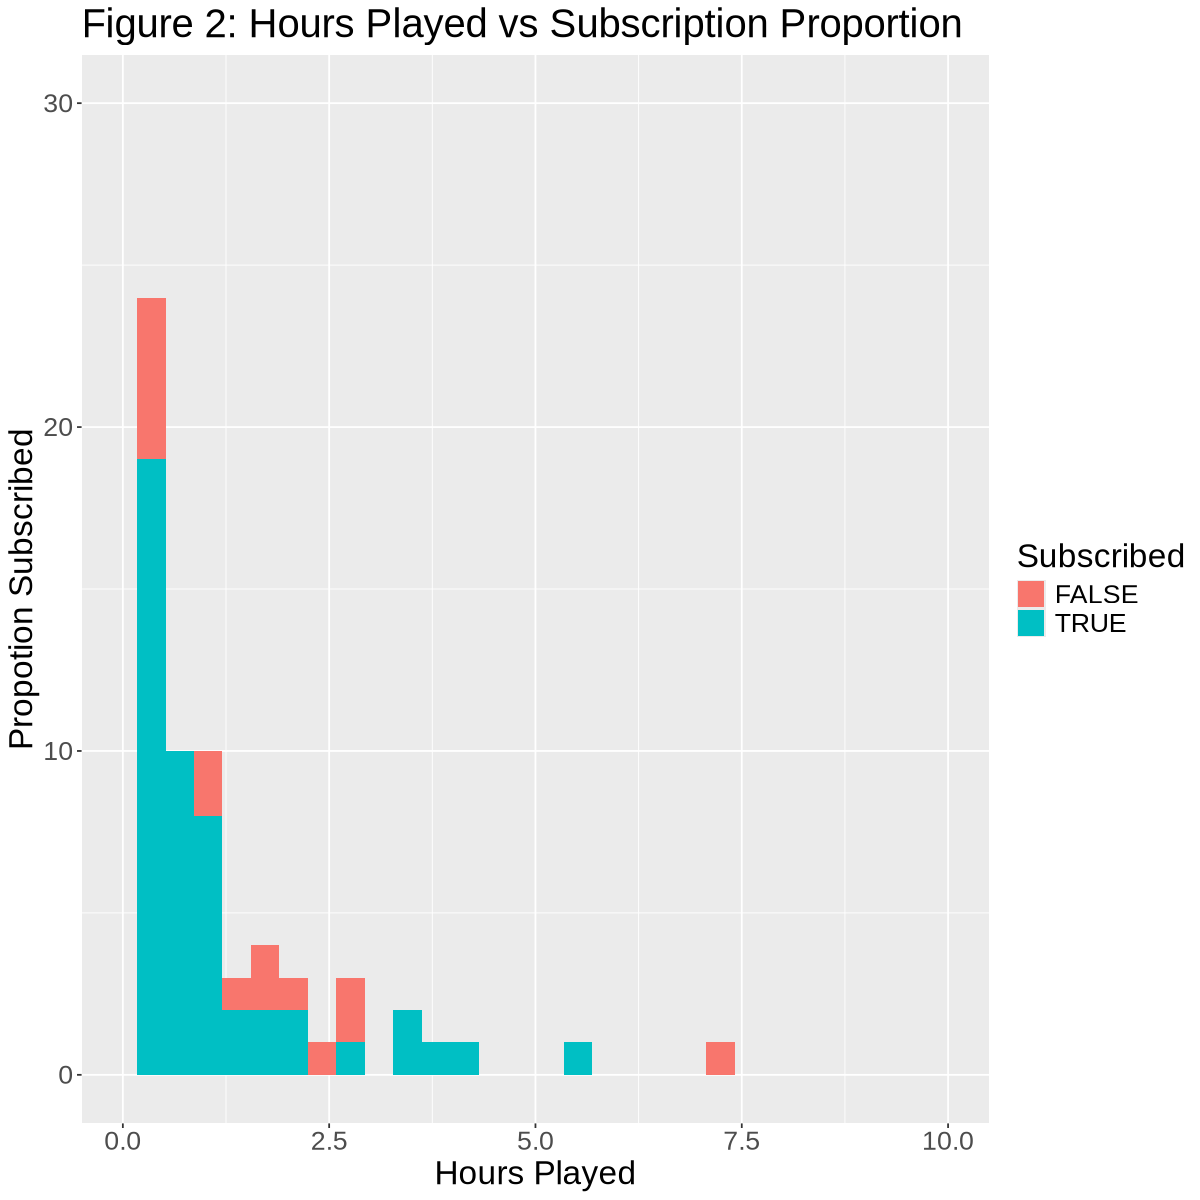

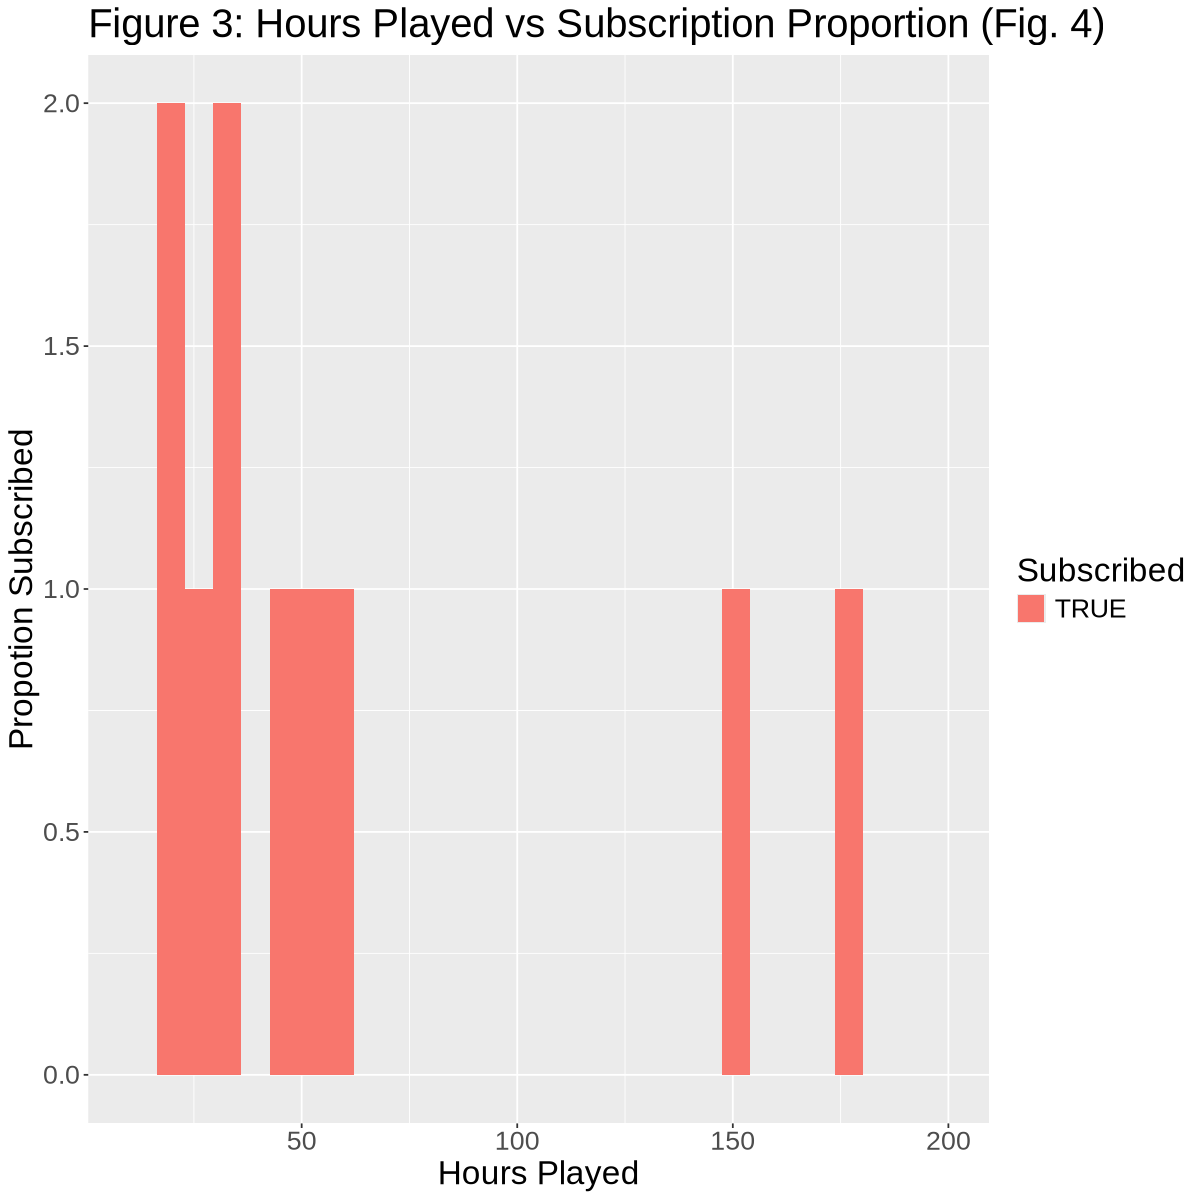

In [25]:
hours_plot_10 <- player_data |> ggplot (aes (x = played_hours, fill = subscribe)) +
    geom_histogram () +
    xlim (c (0, 10)) +
    ylim (c (0, 30)) +
    labs (x = "Hours Played", y = "Propotion Subscribed", fill = "Subscribed") +
    ggtitle ("Figure 2: Hours Played vs Subscription Proportion") +
    theme (text = element_text (size = 20))
hours_plot_10

hours_plot_after_10 <- player_data |> ggplot (aes (x = played_hours, fill = subscribe)) +
    geom_histogram () +
    xlim (c (10, 200)) +
    labs (x = "Hours Played", y = "Propotion Subscribed", fill = "Subscribed") +
    ggtitle ("Figure 3: Hours Played vs Subscription Proportion (Fig. 4)") +
    theme (text = element_text (size = 20))
hours_plot_after_10

We will split the data into 80% training data and 20% testing data. This step is done to test our classifier as it needs to be able to predict on unseen data instead of just memorizing data. 